In [1]:
# example code for plotting stuff form a .txt file
import numpy as np
import matplotlib.pyplot as plt 
import os
import re

from numba import njit, jit
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit



def exponential_decay(lag, tau, A):
    return A * np.exp(-lag / tau)

v_0_run = 20 # micrometers / s

changing_g_no_metnoise_700s_5ms_v20
g0.1
120
g0
120
g0.3
120
g0.5
120
g0.2
120
gradients:  [0.1, 0.0, 0.3, 0.5, 0.2]
[0.27018268 0.00214948]
changing_g_w_metnoise_700s_5ms_v20
g0.1
120
g0
120
g0.3
120
g0.5
120
g0.2
120
gradients:  [0.1, 0.0, 0.3, 0.5, 0.2]
[ 0.25777991 -0.01166003]


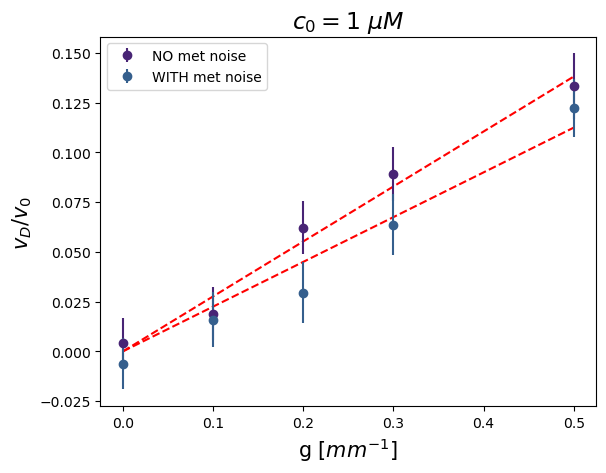

In [ ]:
# Calculating for c0 = 1 the v_x and drift speed 



# rootdir in the form of data_with_metnoise/data_without_metnoisse
# subdirectories : c0=0.1, c0=1, c0=10
# subsubdirectories : g=0, g=0.1, g=0.3 etc.
# example : ../data_with_metnoise/c0_1/g_0.5

# in each g-directory 120 Main_output_#.txt files from running main.py


colors = plt.cm.viridis([0.1, 0.3, 0.6, 0.8]) 


rootdir = "../code/c0_1_no&w_metnoise"
dircmain = [f for f in os.listdir(rootdir) if not f.startswith('.')]
num_dirc = len(dircmain)


label_dir = ["NO met noise", "WITH met noise"] 

# Correct initialization: separate arrays
v_d = np.empty(num_dirc, dtype=object)
var_v_d = np.empty(num_dirc, dtype=object)
mean_v = np.empty(num_dirc, dtype=object)
std_v = np.empty(num_dirc, dtype=object)
pos_x = np.empty(num_dirc, dtype=object)
v_x = np.empty(num_dirc, dtype=object)

count_dir = 0
cc = np.array([0,0,0,0]) # np.array([1, 2, 4]) #this is used in case from running the code, for each c0 all gradients are calculated instead of excluding the ones that we excluded for each drift speed (c0=1 up to g=0.5, c0=10 up to g=0.3, c0 =0.1 up to g=1)
plt.figure(figsize=(6.4, 4.8))

for dirc, dir_label in zip(dircmain, label_dir):
    print(dirc)
    data_dir0 = os.path.join(rootdir, dirc)
    dirnames = [f for f in os.listdir(data_dir0) if not f.startswith('.')]
    num_dir = len(dirnames)
    gradient_g = []
    v_d_list = []
    pos_x_list = []
    v_x_list = []

    num_dir = 0
    if os.path.isdir(data_dir0):
        for dir_name in dirnames:
            num_dir +=1
            print(dir_name)
            match = re.search(r'g([0-9.]+)', dir_name)
            if match:
                g_value = float(match.group(1))
                gradient_g.append(g_value)

            data_dir = os.path.join(data_dir0, dir_name)

            if os.path.isdir(data_dir):
                num_files = len(os.listdir(data_dir)) - 3  # Exclude non-data files
                print(num_files)
                for i in range(num_files):
                    file_path = os.path.join(data_dir, f"Main_output_{i}.txt")
                    data = np.loadtxt(file_path)
                    num_points = int(data[0])
                    v_d_list.append(data[1])
                    pos_x_list.append(data[2:num_points+2])
                    v_x_list.append(data[num_points+2:])

        print('gradients: ', gradient_g)
        pos_x_toreshape = np.array(pos_x_list)

        # pos_x has an additional point/dimension with respect to v_x
        pos_x0 = pos_x_toreshape.T # 3d matrix
        pos_x[count_dir]= pos_x0.reshape(num_points, num_dir, num_files).transpose(0, 2, 1)


        v_x_toreshape = np.array(v_x_list)
        v_x0 = v_x_toreshape.T #.reshape(num_points, num_files) # 3d matrix
        v_x[count_dir] = v_x0.reshape(num_points-1, num_dir, num_files).transpose(0, 2, 1)

        
        
        # Convert v_d_list to array
        v_d_toreshape = np.array(v_d_list)

        # Reshape and transpose to shape (num_files, num_dir)
        v_d[count_dir] = v_d_toreshape.reshape(num_dir, num_files).T

        # Variance, mean, std
        var_v_d[count_dir] = np.var(v_d[count_dir], axis=0) / num_files
        mean_v[count_dir] = np.mean(v_d[count_dir], axis=0)
        std_v[count_dir] = np.sqrt(var_v_d[count_dir])
        
        y = mean_v[count_dir] / v_0_run 
        x = np.array(gradient_g)
        err = std_v[count_dir] / v_0_run 
        
        sorted_indices = np.argsort(x)
        y_sorted= y[sorted_indices]#[0:(len(gradient_g)-cc[count_dir])]

        x_sorted = x[sorted_indices]#[0:(len(gradient_g)-cc[count_dir])]
        err_sorted = err[sorted_indices]#[0:(len(gradient_g)-cc[count_dir])]
        # Fit a line: x as independent, y as dependent
        coef = np.polyfit(x_sorted, y_sorted, 1)
        print(coef)
        poly1d_fn = np.poly1d(coef)
        # Fit a line through the origin: y = m * x
        m_slope = np.sum(x_sorted * y_sorted) / np.sum(x_sorted**2)

        # Create the fitted line
        y_fit = m_slope * x_sorted

        # plt.plot(x_sorted, poly1d_fn(x_sorted), '--r')  # red dashed line (fit only)
        plt.plot(x_sorted, y_fit, '--r')  # red dashed line (fit only)


        
        # Plot
        plt.errorbar(
            x_sorted,
            y_sorted,
            yerr=2 * err_sorted,  # FIXED indexing here
            fmt='o',
            linestyle='none',
            color=colors[count_dir],
            label=dir_label
        )

        count_dir += 1

plt.title(r'$c_0 = 1\ \mu M$', fontsize=17)
plt.xlabel(r'g [$mm^{-1}$]', fontsize=15)
plt.ylabel(r'$v_D / v_0$ ', fontsize=15) # $[\mu m s^{-1}]$', fontsize=15)
plt.legend()
plt.show()

In [ ]:
# Calculating the run and tumble time for each running direction



v_0_value = 20 

#c0_order_array = np.array(c0_order)
#print(c0_order_array)
#indices_c0_order_sorted = np.argsort(c0_order_array)

gradient_g2 = np.array(gradient_g)
print("gradient_g2:", gradient_g2)

#conc1 = c0_order_array
#print("Concentrations:", conc1)

dt_model = 0.005  # seconds

N_conc = 2
print("Number of concentrations:", N_conc)

# Max number of gradients across all vx[c_idx]
N_grad_max = max(v_x[i].shape[2] for i in range(N_conc))
N_traj = v_x[0].shape[1]

N_runs = np.empty(N_conc, dtype=object)
N_tumbles = np.empty(N_conc, dtype=object)

mean_run_time = np.zeros((N_conc, N_grad_max))
mean_tumble_time = np.zeros((N_conc, N_grad_max))

std_run_time = np.zeros((N_conc, N_grad_max))
std_tumble_time = np.zeros((N_conc, N_grad_max))

dir_start_run = np.empty(N_conc, dtype=object)
dir_start_tumble = np.empty(N_conc, dtype=object)

# Use object dtype to store variable-length lists
all_run_lengths = [[[] for _ in range(N_grad_max)] for _ in range(N_conc)]
all_tumble_lengths = [[[] for _ in range(N_grad_max)] for _ in range(N_conc)]

all_run_dirs = [[[] for _ in range(N_grad_max)] for _ in range(N_conc)]
all_tumble_dirs = [[[] for _ in range(N_grad_max)] for _ in range(N_conc)]


for c_idx in range(N_conc):
    current_N_grad = v_x[c_idx].shape[2]

    N_runs[c_idx] = np.zeros((N_traj, current_N_grad))
    N_tumbles[c_idx] = np.zeros((N_traj, current_N_grad))
    dir_start_run[c_idx] = np.empty((N_traj, current_N_grad), dtype=object)
    dir_start_tumble[c_idx] = np.empty((N_traj, current_N_grad), dtype=object)

    count_pos = 0
    count_neg = 0

    for g_idx in range(current_N_grad):
        g_value_loop = gradient_g2[g_idx]
        array_tumbles = []
        array_runs = []
        dir_run = []
        dir_tumble = []
        var_run_traj_i = []
        var_tumble_traj_i = []

        for traj_idx in range(N_traj):
            zero_count = 0
            non_zero_count = 0
            array_tumbles_traj_i = []
            array_runs_traj_i = []

            dir_run_traj_i = []
            dir_tumble_traj_i = []

            prev_non_zero = None
            first_val = - v_x[c_idx][0, traj_idx, g_idx]
            if first_val == 0:
                dir_tumble_traj_i.append(first_val / (v_0_value))
                dir_tumble.append(first_val / (v_0_value ))
            else:
                dir_run_traj_i.append(first_val / (v_0_value ))
                dir_run.append(first_val / (v_0_value ))
                prev_non_zero = first_val

            for i in (- v_x[c_idx][:, traj_idx, g_idx]): # need to add a - becasuse of the wrong sign in the code
                if i == 0:
                    zero_count += 1
                    if non_zero_count > 0:
                        array_runs.append(non_zero_count)
                        array_runs_traj_i.append(non_zero_count)
                        non_zero_count = 0

                        dir_tumble_traj_i.append(prev_non_zero / (v_0_value ))
                        dir_tumble.append(prev_non_zero / (v_0_value ))
                else:
                    non_zero_count += 1
                    if zero_count > 0:
                        array_tumbles.append(zero_count)
                        array_tumbles_traj_i.append(zero_count)
                        zero_count = 0

                        dir_run_traj_i.append(i / (v_0_value ))
                        dir_run.append(i / (v_0_value ))
                        prev_non_zero = i
                    if i < 0: count_neg += 1
                    if i > 0: count_pos += 1
                
            if zero_count > 0:
                array_tumbles.append(zero_count)
                array_tumbles_traj_i.append(zero_count)
            if non_zero_count > 0:
                array_runs.append(non_zero_count)
                array_runs_traj_i.append(non_zero_count)

            N_runs[c_idx][traj_idx, g_idx] = len(array_runs_traj_i)
            N_tumbles[c_idx][traj_idx, g_idx] = len(array_tumbles_traj_i)
            dir_start_run[c_idx][traj_idx, g_idx] = dir_run_traj_i.copy()
            dir_start_tumble[c_idx][traj_idx, g_idx] = dir_tumble_traj_i.copy()

            #print(len(array_runs_traj_i), len(array_tumbles_traj_i), len(dir_run_traj_i), len(dir_tumble_traj_i))



            running_times_traj_i = np.array(array_runs_traj_i) * dt_model
            tumbling_times_traj_i = np.array(array_tumbles_traj_i) * dt_model

            if len(running_times_traj_i) > 0:
                var_run_traj_i.append(np.var(running_times_traj_i) / len(running_times_traj_i))
            if len(tumbling_times_traj_i) > 0:
                var_tumble_traj_i.append(np.var(tumbling_times_traj_i) / len(tumbling_times_traj_i))

        var_run_time = np.mean(var_run_traj_i) if var_run_traj_i else 0
        var_tumble_time = np.mean(var_tumble_traj_i) if var_tumble_traj_i else 0

        tumble_times = np.array(array_tumbles) * dt_model
        run_times = np.array(array_runs) * dt_model

        mean_run_time[c_idx, g_idx] = np.mean(run_times) if len(run_times) > 0 else 0
        std_run_time[c_idx, g_idx] = np.sqrt(var_run_time)

        mean_tumble_time[c_idx, g_idx] = np.mean(tumble_times) if len(tumble_times) > 0 else 0
        std_tumble_time[c_idx, g_idx] = np.sqrt(var_tumble_time)

        # Append full lists of run and tumble lengths and directions
        all_run_lengths[c_idx][g_idx].extend(array_runs)
        all_tumble_lengths[c_idx][g_idx].extend(array_tumbles)
        all_run_dirs[c_idx][g_idx].extend(dir_run)
        all_tumble_dirs[c_idx][g_idx].extend(dir_tumble)

        #print(f"All run directions for c={c_idx}, g={gradient_g2[g_idx]}: {len(all_run_dirs[c_idx][g_idx])}")


    g_vals = gradient_g2[:current_N_grad]


print(gradient_g)
print(gradient_g2)

tot run time rw 6.1813298707122035
tot run time rw 6.15648708981323
tot run time rw 6.531267722772276
tot run time rw 6.625692682926829
tot run time rw 6.354002691272587


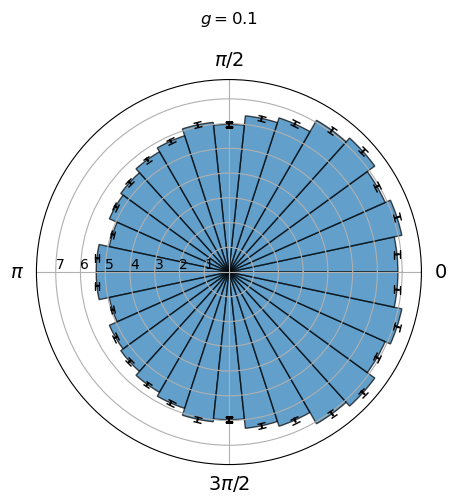

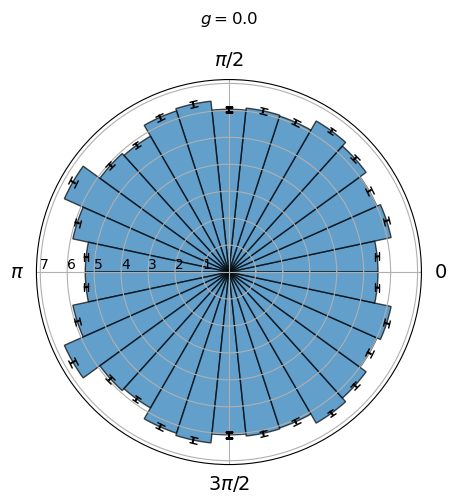

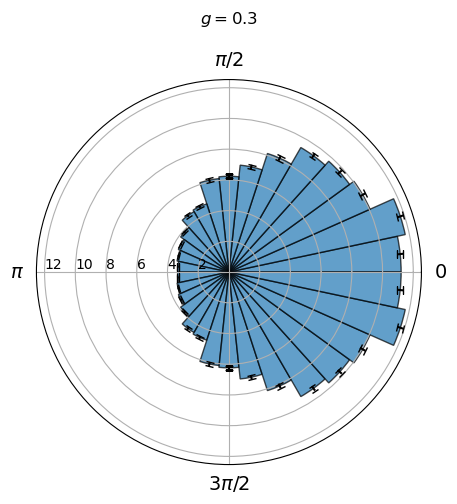

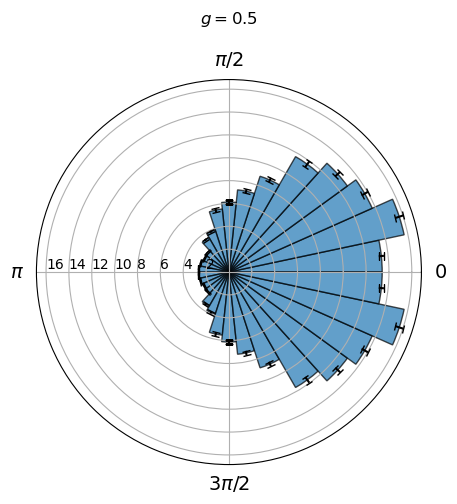

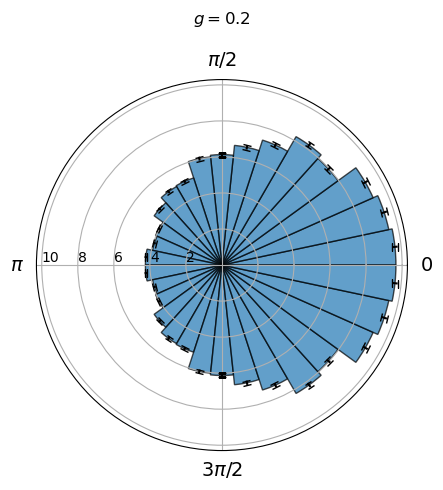

In [ ]:
# Creating a polar histogram for run time for group of directions 



n_bins = 15
bin_edges = np.linspace(0, np.pi, n_bins + 1)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

dt = 0.005  # s

c_idx = 0 # 0 no meth noise, 1 with meth noise, to double check the order once running the script
current_N_grad = v_x[c_idx].shape[2]


N_times_tau_right = np.zeros(current_N_grad)
N_times_tau_wrong = np.zeros(current_N_grad)
err_right_arrary = np.zeros(current_N_grad)
err_wrong_array = np.zeros(current_N_grad)

for g_idx in range(current_N_grad):
    directions = np.array(all_run_dirs[c_idx][g_idx])
    lengths = np.array(all_run_lengths[c_idx][g_idx]) * dt

    num_positive = np.sum(directions > 0)
    idx_pos = directions > 0
    num_lengths = np.sum(lengths[idx_pos])
    #print(num_lengths)
    num_negative = np.sum(directions < 0)
    idx_neg = directions < 0
    num_lengthsneg = np.sum(lengths[idx_neg])
    #print(num_lengthsneg)

    #print(f"Number of positive directions: {num_positive}")
    #print(f"Number of negative directions: {num_negative}")

    

    if len(directions) == 0:
        print(f"No runs for c={c_idx}, g={g_idx}")
        continue

    # Convert cosine values to angles in [0, π]
    angles = np.arccos(directions)

    # Bin in [0, π]
    bin_sums = np.zeros(n_bins)
    bin_err = np.zeros(n_bins)
    tot_run_time = 0

    for i in range(n_bins):
        in_bin = (angles >= bin_edges[i]) & (angles < bin_edges[i + 1])
        if np.any(in_bin):
            num_values = 120 #len(lengths[in_bin])
            bin_sums[i] = np.mean(lengths[in_bin])
            bin_err[i] = 2*np.std(lengths[in_bin]) / num_values
            count0 = np.sum(in_bin)
            tot_run_time_bin = count0*bin_sums[i]
            tot_run_time += tot_run_time_bin
            
        else:
            bin_sums[i] = 0
            bin_err[i] = 0
        #print(np.cos(bin_edges[i]), np.cos(bin_edges[i + 1]), len(directions[in_bin]))
    # Mirror bins across x-axis: θ → 2π - θ

    wrong_dir = (angles >= 0) & (angles < np.pi/2)
    N_wrong = np.sum(wrong_dir)
    tau_wrong = np.mean(lengths[wrong_dir])
    err_wrong_array[g_idx] = np.var(lengths[wrong_dir]) / 120
    right_dir = (angles >= np.pi/2) & (angles < np.pi)
    N_right = np.sum(right_dir)
    tau_right = np.mean(lengths[right_dir])
    err_right_arrary[g_idx] = np.var(lengths[right_dir]) / 120
    tot_run_time_rw = N_right*tau_right + N_wrong*tau_wrong

    N_times_tau_wrong[g_idx] = N_wrong*tau_wrong
    N_times_tau_right[g_idx] = N_right*tau_right

    print(f'tot run time rw {tot_run_time_rw/len(directions)}')
    mirrored_centers = 2 * np.pi - bin_centers
    full_centers = np.concatenate([bin_centers, mirrored_centers])
    full_sums = np.concatenate([bin_sums, bin_sums])
    full_errs = np.concatenate([bin_err, bin_err])

    # Sort by angle
    sort_idx = np.argsort(full_centers)
    full_centers = full_centers[sort_idx]
    full_sums = full_sums[sort_idx]
    full_errs = full_errs[sort_idx]

    # Plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,5))
    bars = ax.bar(full_centers, full_sums, width=bin_width, bottom=0.0,
                  align='center', edgecolor='k', alpha=0.7)

    # Add error bars manually
    for angle, height, err in zip(full_centers, full_sums, full_errs):
        ax.errorbar(angle, height, yerr=err, fmt='o', color='black', capsize=3, markersize=0)

    # Set angular ticks at 0, π/2, π, 3π/2, 2π
    angles_deg = [0, 90, 180, 270]  # in degrees
    angle_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"]

    ax.set_thetagrids(angles_deg, angle_labels, fontsize=14)
    ax.set_rlabel_position(180)  # Move radial labels to the left side


    #ax.set_title(fr"$c_0 = {c0_order[c_idx]}$, $g = {gradient_g2[g_idx]}$")
    ax.set_title(fr"$g = {gradient_g2[g_idx]}$", pad=40)
plt.tight_layout()
plt.show()


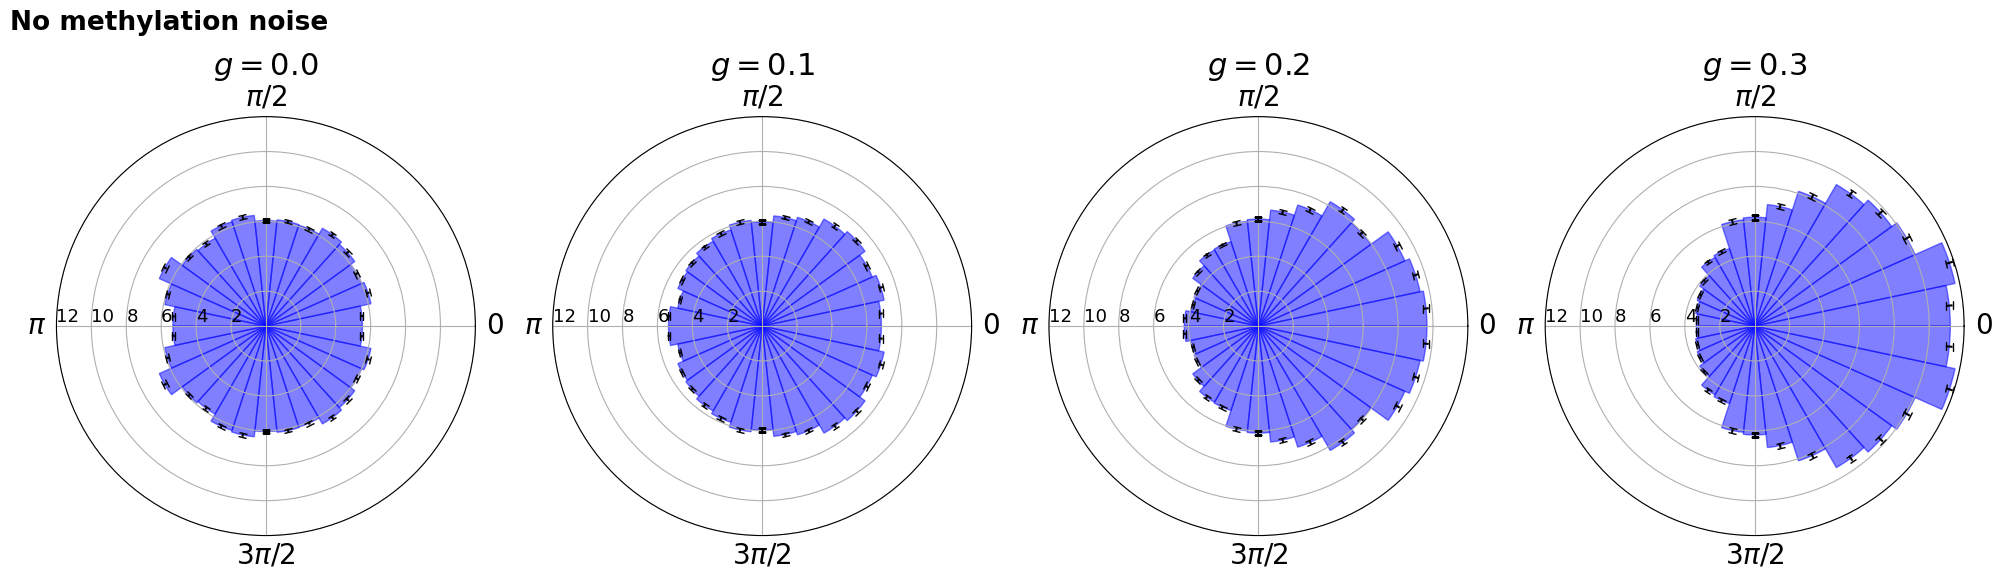

In [ ]:
# Plotting in one graph the prefered polar plots WITHOUT methylation noise for run time



n_bins = 15
bin_edges = np.linspace(0, np.pi, n_bins + 1)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

dt = 0.005  # s

c_idx = 0
current_N_grad = v_x[c_idx].shape[2]

for g_idx in range(current_N_grad):
    directions = np.array(all_run_dirs[c_idx][g_idx])
    lengths = np.array(all_run_lengths[c_idx][g_idx]) * dt

    num_positive = np.sum(directions > 0)
    idx_pos = directions > 0
    num_lengths = np.sum(lengths[idx_pos])
    #print(num_lengths)
    num_negative = np.sum(directions < 0)
    idx_neg = directions < 0
    num_lengthsneg = np.sum(lengths[idx_neg])
    #print(num_lengthsneg)

    #print(f"Number of positive directions: {num_positive}")
    #print(f"Number of negative directions: {num_negative}")

    

    if len(directions) == 0:
        print(f"No runs for c={c_idx}, g={g_idx}")
        continue

    # Convert cosine values to angles in [0, π]
    angles = np.arccos(directions)

    # Bin in [0, π]
    bin_sums = np.zeros(n_bins)
    bin_err = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (angles >= bin_edges[i]) & (angles < bin_edges[i + 1])
        if np.any(in_bin):
            num_values = 120 #len(lengths[in_bin])
            bin_sums[i] = np.mean(lengths[in_bin])
            bin_err[i] = 2*np.std(lengths[in_bin]) / num_values
        else:
            bin_sums[i] = 0
            bin_err[i] = 0
        #print(np.cos(bin_edges[i]), np.cos(bin_edges[i + 1]), len(directions[in_bin]))
    # Mirror bins across x-axis: θ → 2π - θ
    mirrored_centers = 2 * np.pi - bin_centers
    full_centers = np.concatenate([bin_centers, mirrored_centers])
    full_sums = np.concatenate([bin_sums, bin_sums])
    full_errs = np.concatenate([bin_err, bin_err])

    # Sort by angle
    sort_idx = np.argsort(full_centers)
    full_centers = full_centers[sort_idx]
    full_sums = full_sums[sort_idx]
    full_errs = full_errs[sort_idx]

    selected_g_indices = [i for i, g in enumerate(gradient_g2) if g in [0.0, 0.1, 0.2, 0.3]]

fig, axs = plt.subplots(1, len(selected_g_indices), subplot_kw={'projection': 'polar'}, figsize=(5 * len(selected_g_indices), 5))


# note the order of g_values in the array might not be in the expected ascending order 
#selcting the polar plots related to the selcted g_values
selected_g_indices = [1,0,4,2,3] #[0, 5, 3]  # make iterable if only one subplot

for ax, g_idx in zip(axs, selected_g_indices):
    directions = np.array(all_run_dirs[c_idx][g_idx])
    lengths = np.array(all_run_lengths[c_idx][g_idx]) * dt

    if len(directions) == 0:
        print(f"No runs for c={c_idx}, g={g_idx}")
        continue

    angles = np.arccos(directions)
    bin_sums = np.zeros(n_bins)
    bin_err = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (angles >= bin_edges[i]) & (angles < bin_edges[i + 1])
        if np.any(in_bin):
            num_values = 120
            bin_sums[i] = np.mean(lengths[in_bin])
            bin_err[i] = 2 * np.std(lengths[in_bin]) / num_values

    mirrored_centers = 2 * np.pi - bin_centers
    full_centers = np.concatenate([bin_centers, mirrored_centers])
    full_sums = np.concatenate([bin_sums, bin_sums])
    full_errs = np.concatenate([bin_err, bin_err])

    sort_idx = np.argsort(full_centers)
    full_centers = full_centers[sort_idx]
    full_sums = full_sums[sort_idx]
    full_errs = full_errs[sort_idx]

    ax.bar(full_centers, full_sums, width=bin_width, bottom=0.0,
           align='center', color='b', alpha=0.5, edgecolor='b')

    for angle, height, err in zip(full_centers, full_sums, full_errs):
        ax.errorbar(angle, height, yerr=err, fmt='o', color='black', capsize=3, markersize=0)
    
    ax.set_ylim(0, 12)
    ax.tick_params(axis='y', labelsize=13)

    ax.set_thetagrids([0, 90, 180, 270], [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"], fontsize=20)
    ax.set_rlabel_position(180)
    ax.set_title(fr"$g = {gradient_g2[g_idx]}$", pad=30, fontsize=22)

fig.text(0.00001, 1.1, "No methylation noise", fontsize=19, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()


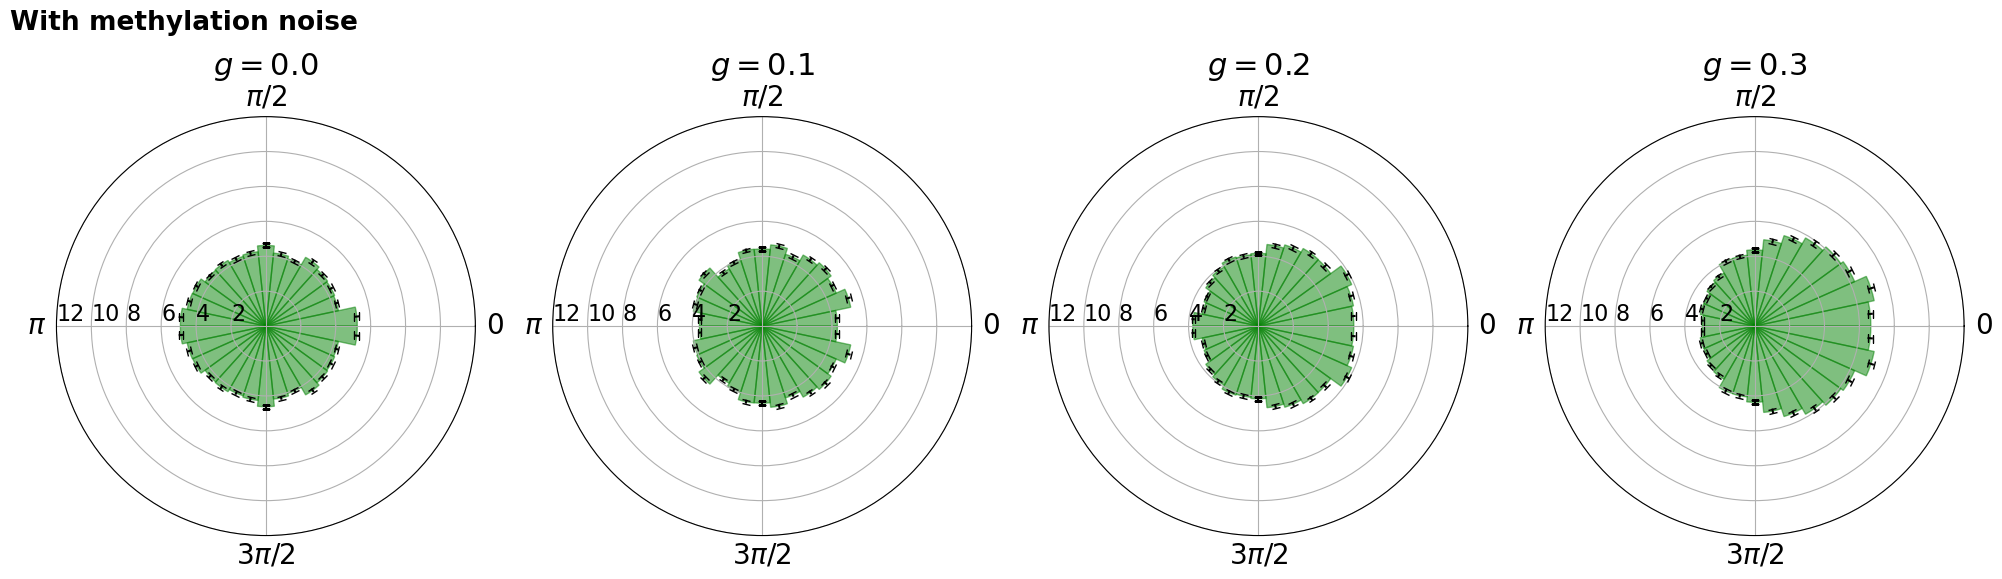

In [ ]:
# Plotting in one graph the prefered polar plots WITH methylation noise for run time



n_bins = 15
bin_edges = np.linspace(0, np.pi, n_bins + 1)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

dt = 0.005  # s

c_idx = 1
current_N_grad = v_x[c_idx].shape[2]

for g_idx in range(current_N_grad):
    directions = np.array(all_run_dirs[c_idx][g_idx])
    lengths = np.array(all_run_lengths[c_idx][g_idx]) * dt

    num_positive = np.sum(directions > 0)
    idx_pos = directions > 0
    num_lengths = np.sum(lengths[idx_pos])
    #print(num_lengths)
    num_negative = np.sum(directions < 0)
    idx_neg = directions < 0
    num_lengthsneg = np.sum(lengths[idx_neg])
    #print(num_lengthsneg)

    #print(f"Number of positive directions: {num_positive}")
    #print(f"Number of negative directions: {num_negative}")

    

    if len(directions) == 0:
        print(f"No runs for c={c_idx}, g={g_idx}")
        continue

    # Convert cosine values to angles in [0, π]
    angles = np.arccos(directions)

    # Bin in [0, π]
    bin_sums = np.zeros(n_bins)
    bin_err = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (angles >= bin_edges[i]) & (angles < bin_edges[i + 1])
        if np.any(in_bin):
            num_values = 120 #len(lengths[in_bin])
            bin_sums[i] = np.mean(lengths[in_bin])
            bin_err[i] = 2*np.std(lengths[in_bin]) / num_values
        else:
            bin_sums[i] = 0
            bin_err[i] = 0
        #print(np.cos(bin_edges[i]), np.cos(bin_edges[i + 1]), len(directions[in_bin]))
    # Mirror bins across x-axis: θ → 2π - θ
    mirrored_centers = 2 * np.pi - bin_centers
    full_centers = np.concatenate([bin_centers, mirrored_centers])
    full_sums = np.concatenate([bin_sums, bin_sums])
    full_errs = np.concatenate([bin_err, bin_err])

    # Sort by angle
    sort_idx = np.argsort(full_centers)
    full_centers = full_centers[sort_idx]
    full_sums = full_sums[sort_idx]
    full_errs = full_errs[sort_idx]

    selected_g_indices = [i for i, g in enumerate(gradient_g2) if g in [0.0, 0.1, 0.2, 0.3]]

fig, axs = plt.subplots(1, len(selected_g_indices), subplot_kw={'projection': 'polar'}, figsize=(5 * len(selected_g_indices), 5))

selected_g_indices = [1,0, 4,2,3]  # make iterable if only one subplot

for ax, g_idx in zip(axs, selected_g_indices):
    directions = np.array(all_run_dirs[c_idx][g_idx])
    lengths = np.array(all_run_lengths[c_idx][g_idx]) * dt

    if len(directions) == 0:
        print(f"No runs for c={c_idx}, g={g_idx}")
        continue

    angles = np.arccos(directions)
    bin_sums = np.zeros(n_bins)
    bin_err = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (angles >= bin_edges[i]) & (angles < bin_edges[i + 1])
        if np.any(in_bin):
            num_values = 120
            bin_sums[i] = np.mean(lengths[in_bin])
            bin_err[i] = 2 * np.std(lengths[in_bin]) / num_values

    mirrored_centers = 2 * np.pi - bin_centers
    full_centers = np.concatenate([bin_centers, mirrored_centers])
    full_sums = np.concatenate([bin_sums, bin_sums])
    full_errs = np.concatenate([bin_err, bin_err])

    sort_idx = np.argsort(full_centers)
    full_centers = full_centers[sort_idx]
    full_sums = full_sums[sort_idx]
    full_errs = full_errs[sort_idx]

    ax.bar(full_centers, full_sums, width=bin_width, bottom=0.0,
           align='center', color='g', alpha=0.5, edgecolor='g')

    for angle, height, err in zip(full_centers, full_sums, full_errs):
        ax.errorbar(angle, height, yerr=err, fmt='o', color='black', capsize=3, markersize=0)
    
    ax.set_ylim(0, 12)
    ax.tick_params(axis='y', labelsize=16)

    ax.set_thetagrids([0, 90, 180, 270], [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"], fontsize=20)
    ax.set_rlabel_position(180)
    ax.set_title(fr"$g = {gradient_g2[g_idx]}$", pad=30, fontsize=22)

fig.text(0.00001, 1.1, "With methylation noise", fontsize=19, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()


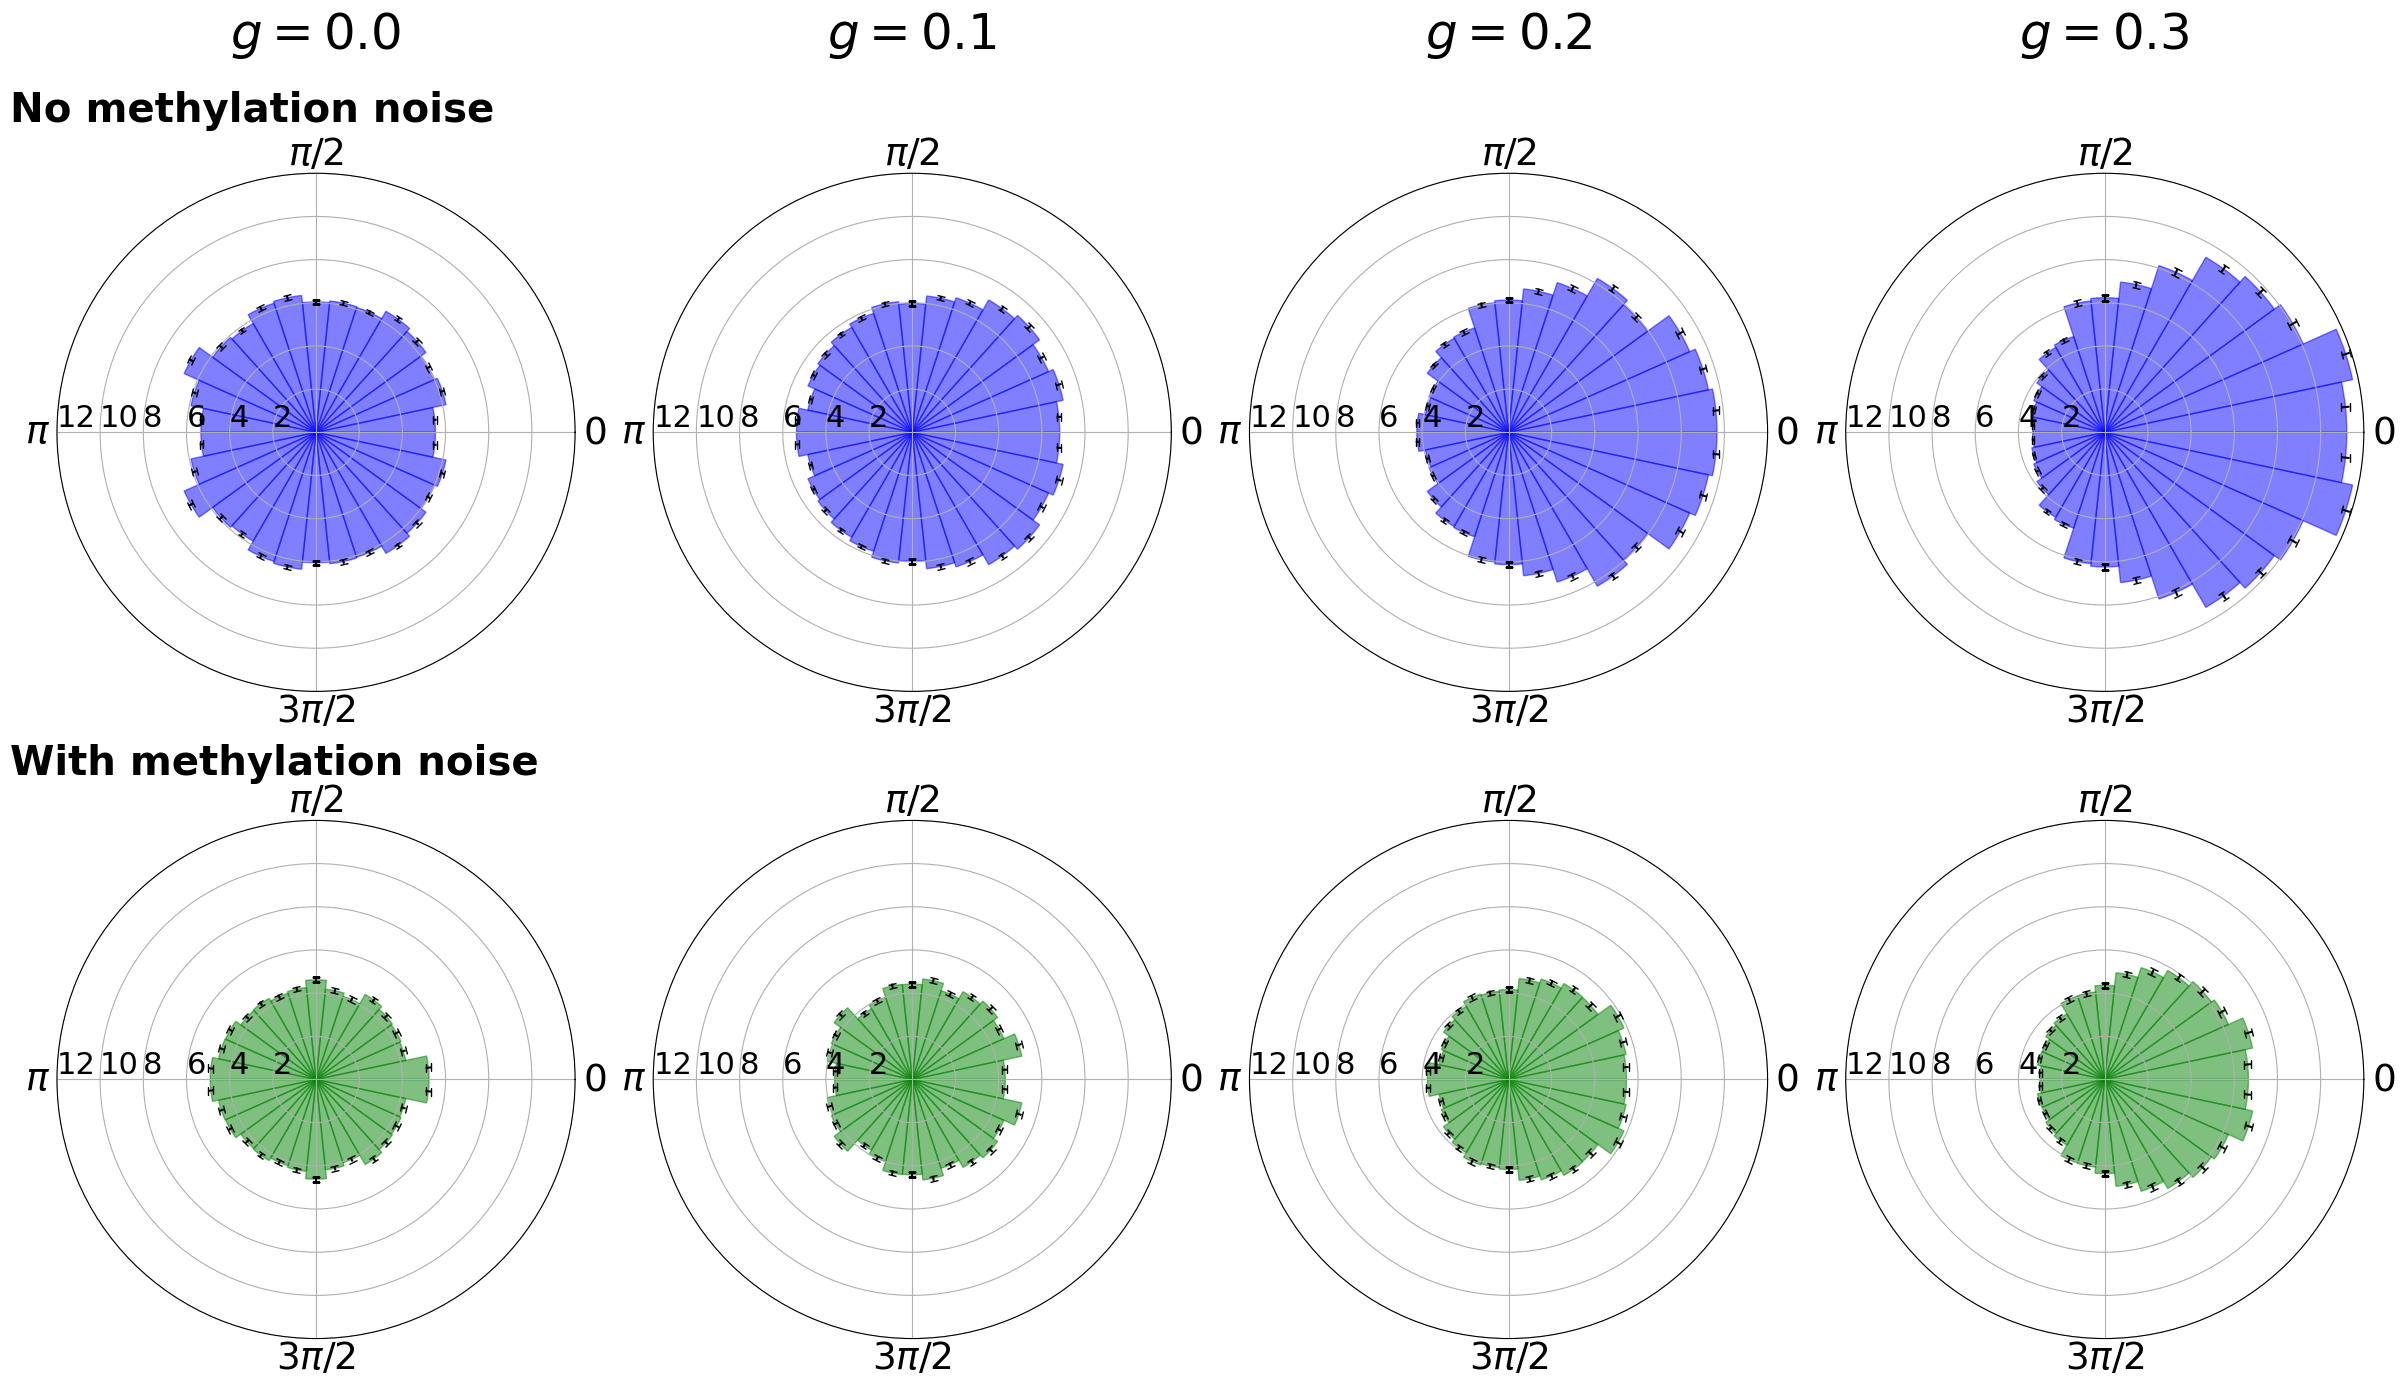

In [ ]:
# Plotting in one graph the prefered polar plots WITHOUT and WITH methylation noise for run time



n_bins = 15
bin_edges = np.linspace(0, np.pi, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]
dt = 0.005  # s

selected_g_indices = [1, 0, 4, 2]

fig, axs = plt.subplots(2, len(selected_g_indices),
                        subplot_kw={'projection': 'polar'},
                        figsize=(6 * len(selected_g_indices), 14.5))  # height doubled

# ===== First row: No methylation noise =====
c_idx = 0
for ax, g_idx in zip(axs[0], selected_g_indices):
    directions = np.array(all_run_dirs[c_idx][g_idx])
    lengths = np.array(all_run_lengths[c_idx][g_idx]) * dt

    if len(directions) == 0:
        continue

    angles = np.arccos(directions)
    bin_sums = np.zeros(n_bins)
    bin_err = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (angles >= bin_edges[i]) & (angles < bin_edges[i + 1])
        if np.any(in_bin):
            num_values = 120
            bin_sums[i] = np.mean(lengths[in_bin])
            bin_err[i] = 2 * np.std(lengths[in_bin]) / num_values

    mirrored_centers = 2 * np.pi - bin_centers
    full_centers = np.concatenate([bin_centers, mirrored_centers])
    full_sums = np.concatenate([bin_sums, bin_sums])
    full_errs = np.concatenate([bin_err, bin_err])

    sort_idx = np.argsort(full_centers)
    full_centers, full_sums, full_errs = full_centers[sort_idx], full_sums[sort_idx], full_errs[sort_idx]

    ax.bar(full_centers, full_sums, width=bin_width, bottom=0.0,
           align='center', color='b', alpha=0.5, edgecolor='b')

    for angle, height, err in zip(full_centers, full_sums, full_errs):
        ax.errorbar(angle, height, yerr=err, fmt='o', color='black', capsize=3, markersize=0)

    ax.set_ylim(0, 12)
    ax.tick_params(axis='y', labelsize=22)
    ax.set_thetagrids([0, 90, 180, 270],
                      [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"],
                      fontsize=27)
    ax.set_rlabel_position(180)
    ax.set_title(fr"$g = {gradient_g2[g_idx]}$", fontweight='bold', pad=90, fontsize=36)

# ===== Second row: With methylation noise =====
c_idx = 1
for ax, g_idx in zip(axs[1], selected_g_indices):
    directions = np.array(all_run_dirs[c_idx][g_idx])
    lengths = np.array(all_run_lengths[c_idx][g_idx]) * dt

    if len(directions) == 0:
        continue

    angles = np.arccos(directions)
    bin_sums = np.zeros(n_bins)
    bin_err = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (angles >= bin_edges[i]) & (angles < bin_edges[i + 1])
        if np.any(in_bin):
            num_values = 120
            bin_sums[i] = np.mean(lengths[in_bin])
            bin_err[i] = 2 * np.std(lengths[in_bin]) / num_values

    mirrored_centers = 2 * np.pi - bin_centers
    full_centers = np.concatenate([bin_centers, mirrored_centers])
    full_sums = np.concatenate([bin_sums, bin_sums])
    full_errs = np.concatenate([bin_err, bin_err])

    sort_idx = np.argsort(full_centers)
    full_centers, full_sums, full_errs = full_centers[sort_idx], full_sums[sort_idx], full_errs[sort_idx]

    ax.bar(full_centers, full_sums, width=bin_width, bottom=0.0,
           align='center', color='g', alpha=0.5, edgecolor='g')

    for angle, height, err in zip(full_centers, full_sums, full_errs):
        ax.errorbar(angle, height, yerr=err, fmt='o', color='black', capsize=3, markersize=0)

    ax.set_ylim(0, 12)
    ax.tick_params(axis='y', labelsize=22)
    ax.set_thetagrids([0, 90, 180, 270],
                      [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"],
                      fontsize=27)
    ax.set_rlabel_position(180)
    #ax.set_title(fr"$g = {gradient_g2[g_idx]}$", pad=30, fontsize=26)

# Row labels
fig.text(0.00001, 0.92, "No methylation noise", fontsize=29, fontweight='bold', va='top', ha='left')
fig.text(0.00001, 0.47, "With methylation noise", fontsize=29, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()



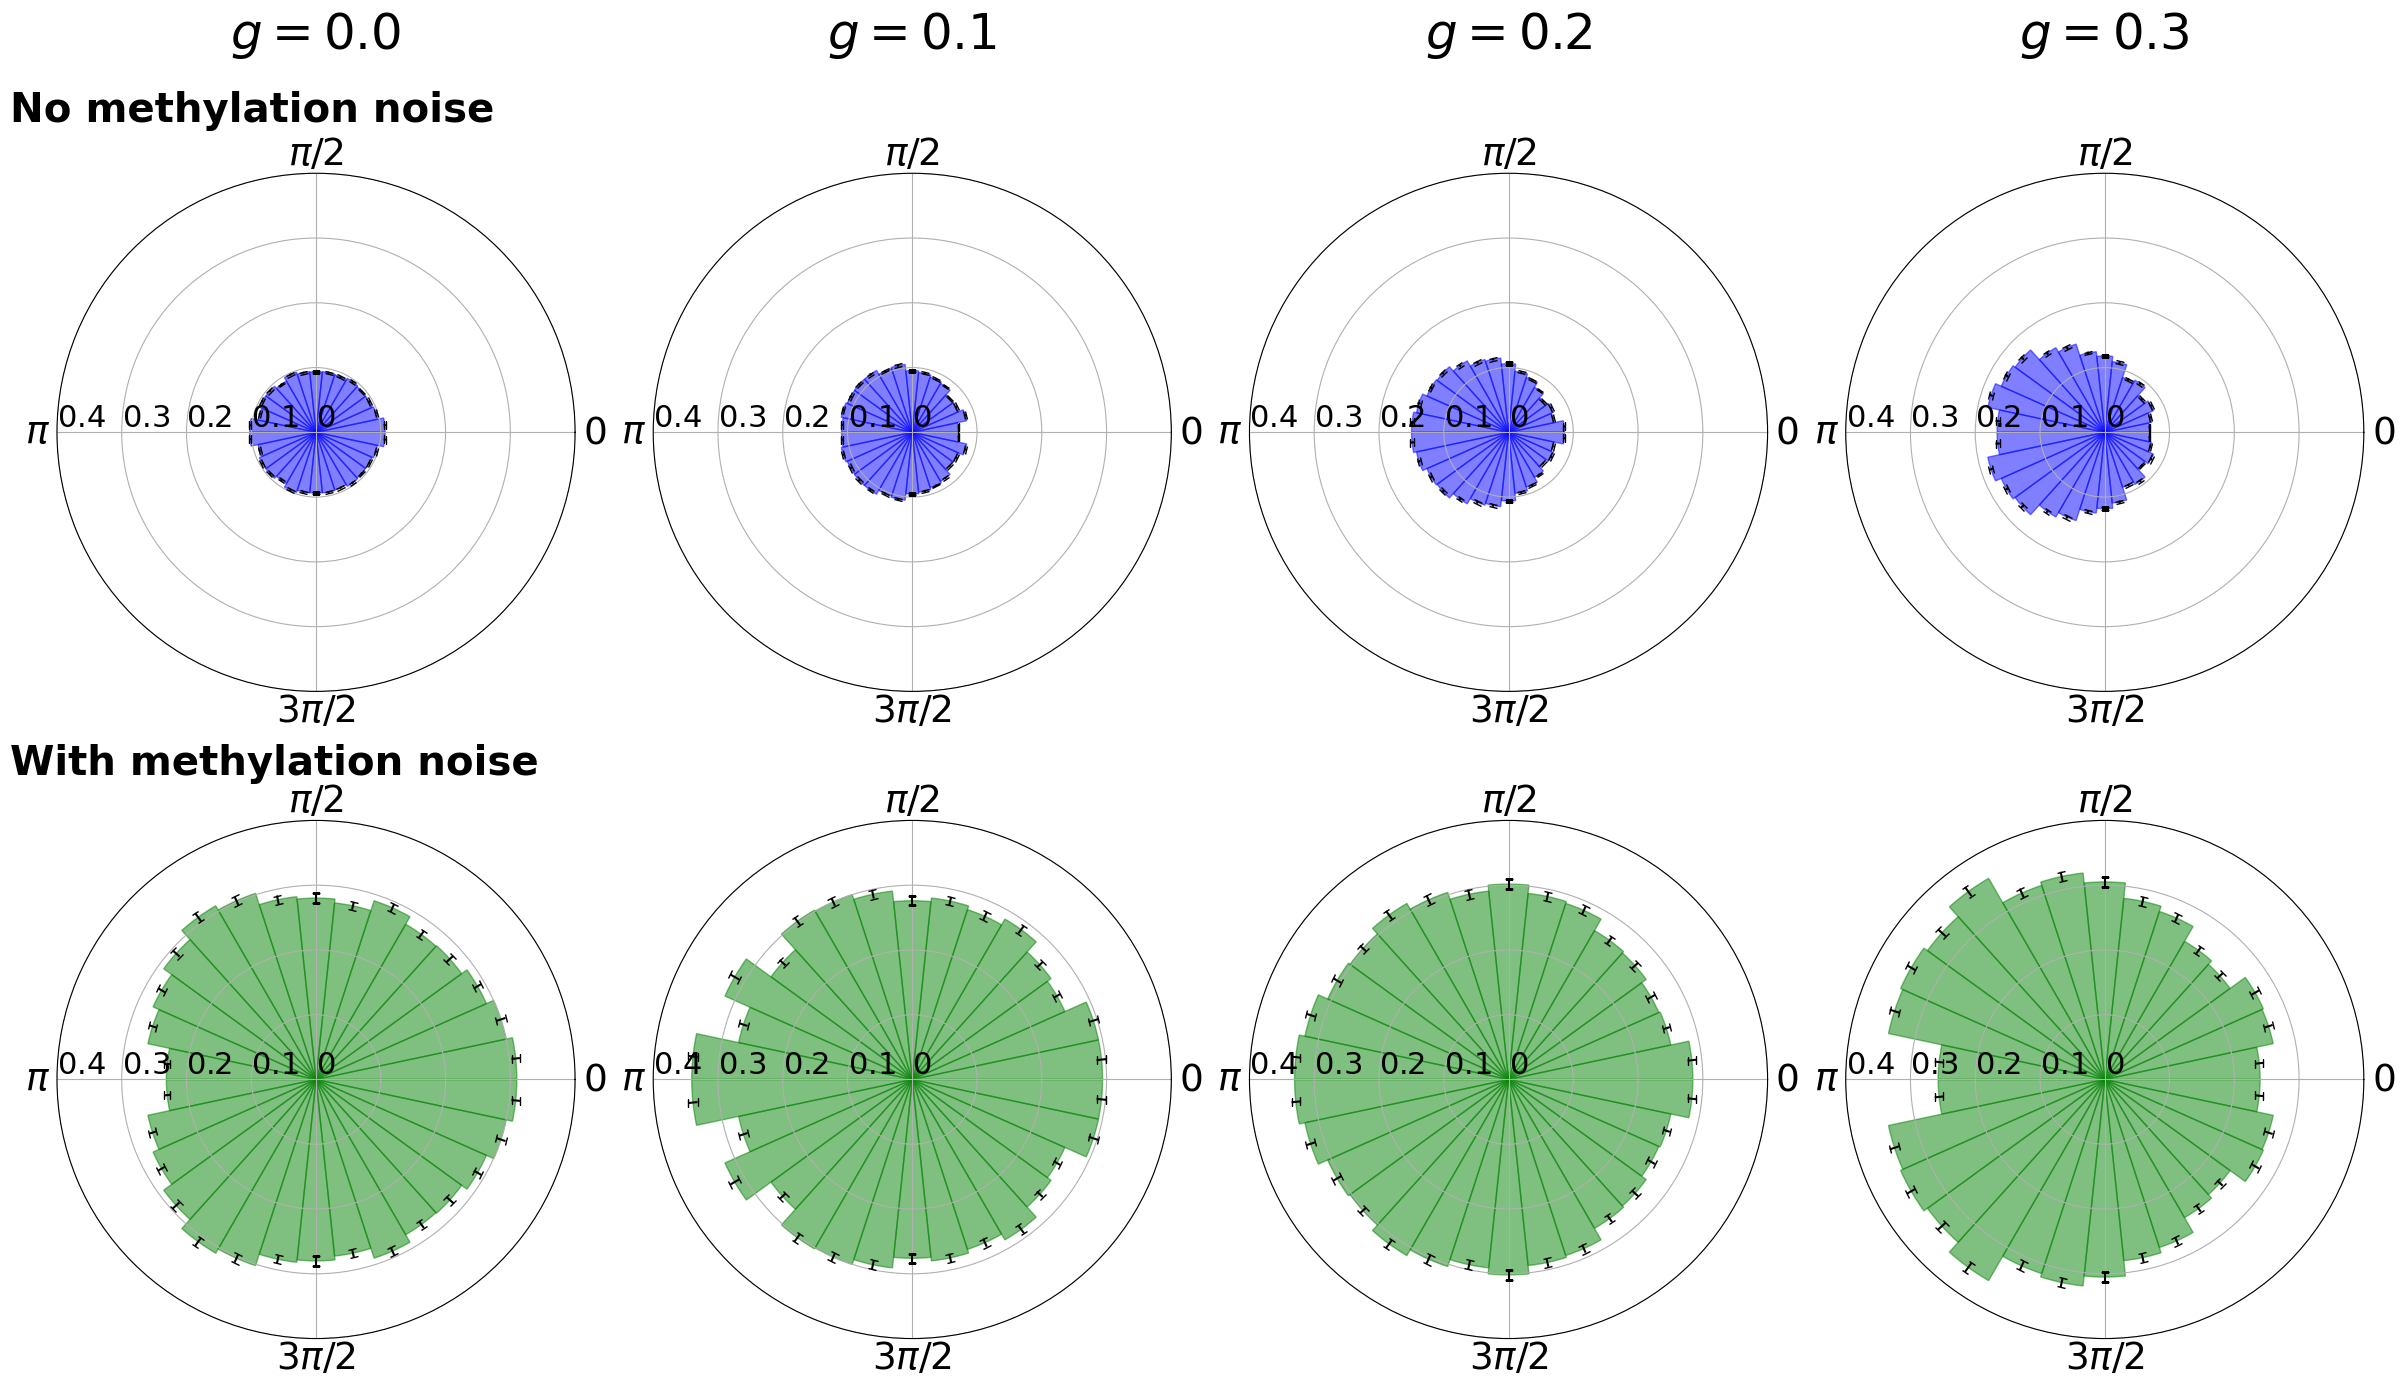

In [ ]:
# Plotting in one graph the prefered polar plots WITHOUT and WITH methylation noise for tumble time
n_bins = 15
bin_edges = np.linspace(0, np.pi, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]
dt = 0.005  # s

selected_g_indices = [1, 0, 4, 2]

fig, axs = plt.subplots(2, len(selected_g_indices),
                        subplot_kw={'projection': 'polar'},
                        figsize=(6 * len(selected_g_indices), 14.5))  # height doubled

# ===== First row: No methylation noise =====
c_idx = 0
for ax, g_idx in zip(axs[0], selected_g_indices):
    directions = np.array(all_tumble_dirs[c_idx][g_idx])
    lengths = np.array(all_tumble_lengths[c_idx][g_idx]) * dt

    if len(directions) == 0:
        continue

    angles = np.arccos(directions)
    bin_sums = np.zeros(n_bins)
    bin_err = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (angles >= bin_edges[i]) & (angles < bin_edges[i + 1])
        if np.any(in_bin):
            num_values = 120
            bin_sums[i] = np.mean(lengths[in_bin])
            bin_err[i] = 2 * np.std(lengths[in_bin]) / num_values

    mirrored_centers = 2 * np.pi - bin_centers
    full_centers = np.concatenate([bin_centers, mirrored_centers])
    full_sums = np.concatenate([bin_sums, bin_sums])
    full_errs = np.concatenate([bin_err, bin_err])

    sort_idx = np.argsort(full_centers)
    full_centers, full_sums, full_errs = full_centers[sort_idx], full_sums[sort_idx], full_errs[sort_idx]

    ax.bar(full_centers, full_sums, width=bin_width, bottom=0.0,
           align='center', color='b', alpha=0.5, edgecolor='b')

    for angle, height, err in zip(full_centers, full_sums, full_errs):
        ax.errorbar(angle, height, yerr=err, fmt='o', color='black', capsize=3, markersize=0)

    ax.set_ylim(0, 0.4)
    ax.set_rticks([0, 0.1, 0.2,0.3, 0.4], [r"$0$", r"$0.1$", r"$0.2$", r"$0.3$", r"$0.4$"])
    ax.tick_params(axis='y', labelsize=22)
    ax.set_thetagrids([0, 90, 180, 270],
                      [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"],
                      fontsize=27)
    ax.set_rlabel_position(180)
    ax.set_title(fr"$g = {gradient_g2[g_idx]}$", fontweight='bold', pad=90, fontsize=36)

# ===== Second row: With methylation noise =====
c_idx = 1
for ax, g_idx in zip(axs[1], selected_g_indices):
    directions = np.array(all_tumble_dirs[c_idx][g_idx])
    lengths = np.array(all_tumble_lengths[c_idx][g_idx]) * dt

    if len(directions) == 0:
        continue

    angles = np.arccos(directions)
    bin_sums = np.zeros(n_bins)
    bin_err = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (angles >= bin_edges[i]) & (angles < bin_edges[i + 1])
        if np.any(in_bin):
            num_values = 120
            bin_sums[i] = np.mean(lengths[in_bin])
            bin_err[i] = 2 * np.std(lengths[in_bin]) / num_values

    mirrored_centers = 2 * np.pi - bin_centers
    full_centers = np.concatenate([bin_centers, mirrored_centers])
    full_sums = np.concatenate([bin_sums, bin_sums])
    full_errs = np.concatenate([bin_err, bin_err])

    sort_idx = np.argsort(full_centers)
    full_centers, full_sums, full_errs = full_centers[sort_idx], full_sums[sort_idx], full_errs[sort_idx]

    ax.bar(full_centers, full_sums, width=bin_width, bottom=0.0,
           align='center', color='g', alpha=0.5, edgecolor='g')

    for angle, height, err in zip(full_centers, full_sums, full_errs):
        ax.errorbar(angle, height, yerr=err, fmt='o', color='black', capsize=3, markersize=0)

    ax.set_ylim(0, 0.4)
    ax.set_rticks([0, 0.1, 0.2,0.3, 0.4], [r"$0$", r"$0.1$", r"$0.2$", r"$0.3$", r"$0.4$"])
    ax.tick_params(axis='y', labelsize=22)
    ax.set_thetagrids([0, 90, 180, 270],
                      [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"],
                      fontsize=27)
    ax.set_rlabel_position(180)
    #ax.set_title(fr"$g = {gradient_g2[g_idx]}$", pad=30, fontsize=26)

# Row labels
fig.text(0.00001, 0.92, "No methylation noise", fontsize=29, fontweight='bold', va='top', ha='left')
fig.text(0.00001, 0.47, "With methylation noise", fontsize=29, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()
